In [2]:
import os
import numpy as np
import itertools as it
import pandas as pd
from types import SimpleNamespace
import matplotlib.pyplot as plt

# see https://stackoverflow.com/questions/41385708/multiprocessing-example-giving-attributeerror
# for why we use multiprocess rather than multiprocessing,
from multiprocess import Pool

import src.utils as utils
import src.initial as initial
import src.target as target
from src.proposals import norm
import src.mcmc as mcmc

utils.configure_pd(pd)
utils.configure_plt(plt)

In [4]:
d, ell2 = 100, 2.38**2

mode_pairs_grid = [('full_max_indep','na'),
                   ('full_max_refl','na'),
                   ('max_indep','same_u'),
                   ('max_indep','cond_same_u'),
                   ('max_refl','same_u'),
                   ('max_refl','cond_same_u')]

# for paper, n_rep = 1000
pl = utils.add_iter([{'n_rep':10, 'n_iter':2500,
                      'prop_mode':prop_mode, 'ar_mode':ar_mode,
                      'd':d, 'ell2':ell2}
                     for (prop_mode, ar_mode) in mode_pairs_grid])

def f(par):
    n = SimpleNamespace(**par)
    pr = f' - d = {n.d}, prop_mode = {n.prop_mode}, ar_mode = {n.ar_mode} ({n.i}/{n.i_total})'

    init = initial.Initialize(d=n.d, mode='target_indep')
    prop = norm.NormalProposal(d=n.d, sigma2=n.ell2/n.d, prop_mode=n.prop_mode)
    targ = target.NormalTarget(d=n.d, sigma2=1)

    # break_condition='none', so we run t = 1,...,n_iter no matter what
    cmh = mcmc.CoupledMH(init, prop, targ, break_condition='none',
                         ar_mode=n.ar_mode, record_items=('r'))
    cmh.run(n_iter=n.n_iter, n_rep=n.n_rep, verbose=True, pr_postfix=pr)

    df0 = cmh.return_df()
    df0['mode'] = f'{n.prop_mode} {n.ar_mode}'
    return df0

df_list = []
with Pool(os.cpu_count()-2) as p:
    df_list += p.map(f, pl)

df = pd.concat(df_list)

1 - d = 100, prop_mode = full_max_indep, ar_mode = na (0/6)1 - d = 100, prop_mode = full_max_refl, ar_mode = na (1/6)1 - d = 100, prop_mode = max_indep, ar_mode = same_u (2/6)1 - d = 100, prop_mode = max_refl, ar_mode = same_u (4/6)1 - d = 100, prop_mode = max_indep, ar_mode = cond_same_u (3/6)


1 - d = 100, prop_mode = max_refl, ar_mode = cond_same_u (5/6)


2 - d = 100, prop_mode = max_refl, ar_mode = same_u (4/6)
2 - d = 100, prop_mode = max_indep, ar_mode = same_u (2/6)
3 - d = 100, prop_mode = max_refl, ar_mode = same_u (4/6)
4 - d = 100, prop_mode = max_refl, ar_mode = same_u (4/6)
2 - d = 100, prop_mode = full_max_indep, ar_mode = na (0/6)
3 - d = 100, prop_mode = max_indep, ar_mode = same_u (2/6)
5 - d = 100, prop_mode = max_refl, ar_mode = same_u (4/6)
6 - d = 100, prop_mode = max_refl, ar_mode = same_u (4/6)
4 - d = 100, prop_mode = max_indep, ar_mode = same_u (2/6)
7 - d = 100, prop_mode = max_refl, ar_mode = same_u (4/6)
3 - d = 100, prop_mode = full_max_indep, ar_mode = n

In [5]:
# process output
#res_list2 = [r for res in res_list for r in res]
#df = pd.concat(pd.DataFrame(res) for res in res_list2)

df_avg = df.groupby(['mode','t']).mean().reset_index()

df_p = df_avg.pivot(index='t',columns='mode',values='r_curr')
mode_summary = df_p.columns.tolist()
df_p.reset_index(inplace=True)

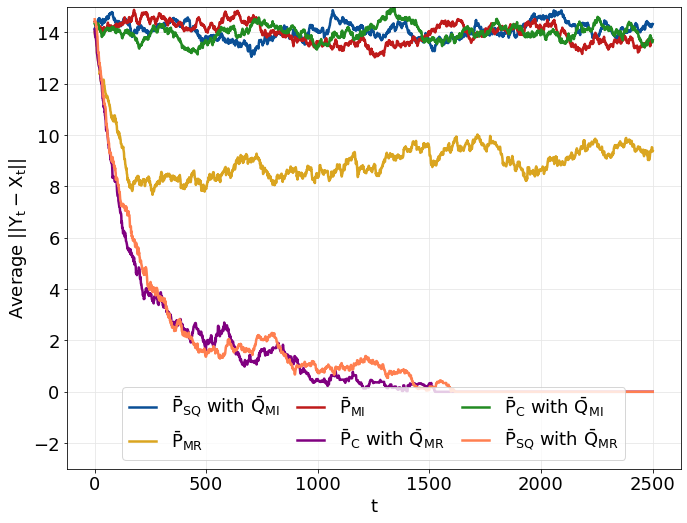

In [15]:
# Produce Figure 8: avg distance between chains by iteration and coupling

mode_disp = ['max_indep same_u',
            'full_max_indep na',
            'max_indep cond_same_u',
            'full_max_refl na',
            'max_refl cond_same_u',
            'max_refl same_u']

mode_labs = [r'$\bar{P}_{SQ}$ with $\bar{Q}_{MI}$',
            r'$\bar{P}_{MI}$',
            r'$\bar{P}_C$ with $\bar{Q}_{MI}$',
            r'$\bar{P}_{MR}$',
            r'$\bar{P}_C$ with $\bar{Q}_{MR}$',
            r'$\bar{P}_{SQ}$ with $\bar{Q}_{MR}$',
]

ax = df_p.plot(x='t', y=mode_disp)

handles, labels = ax.get_legend_handles_labels()
ord = [0,3,1,4,2,5]
handles2 = [handles[i] for i in ord]
labels2 = [mode_labs[i] for i in ord]
plt.legend(labels=labels2, handles=handles2, loc='lower center',
           ncol=3, handlelength=1.5, columnspacing=1)

plt.xlabel('t')
plt.ylabel(r'Average $||Y_t-X_t||$')

plt.ylim(ymin=-3, ymax=15)

plt.show()
